In [18]:
import collections
import datetime
import time

from dateutil import rrule
from dateutil.parser import parse
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from beancount.core import data
from beancount.ops import holdings
from beancount import loader
from beancount.reports import holdings_reports

plt.style.use('ggplot')

In [3]:
filename = '/home/alex/finance/money.beancount'

In [4]:
entries, errors, options_map = loader.load_file(filename)

In [5]:
for entry in entries:
    if isinstance(entry, data.Transaction):
        dtstart = entry.date
        break

In [8]:
net_worths_dict = collections.defaultdict(list)
index = 0
current_entries = []
dtend = datetime.date.today()
period = rrule.rrule(rrule.WEEKLY, byweekday=rrule.FR, dtstart=dtstart, until=dtend)

In [9]:
    for dtime in period:
        date = dtime.date()
        logging.info(date)

        # Append new entries until the given date.
        while True:
            entry = entries[index]
            if entry.date >= date:
                break
            current_entries.append(entry)
            index += 1

        # Get the list of holdings.
        raw_holdings_list, price_map = holdings_reports.get_assets_holdings(current_entries,
                                                                            options_map)

        # Convert the currencies.
        for currency in options_map['operating_currency']:
            holdings_list = holdings.convert_to_currency(price_map,
                                                         currency,
                                                         raw_holdings_list)

            holdings_list = holdings.aggregate_holdings_by(
                holdings_list, lambda holding: holding.cost_currency)

            holdings_list = [holding
                             for holding in holdings_list
                             if holding.currency and holding.cost_currency]

            # If after conversion there are no valid holdings, skip the currency
            # altogether.
            if not holdings_list:
                continue

            net_worths_dict[currency].append((date, holdings_list[0].market_value))

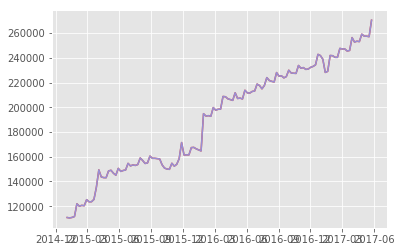

In [28]:
lists = net_worths_dict['GBP']
x, y = zip(*lists)

#fig, ax = plt.subplots()

plt.plot(x, y)
plt.show()